## **Burgers' Equation: Forward Continuous Problem**

This notebook solves the **forward problem** for the 1D Burgers' equation. Given the initial and boundary conditions, we train a Physics-Informed Neural Network (PINN) to predict the solution $u(x,t)$.

We will compare two optimization strategies:
1.  **Replication:** Using only the L-BFGS optimizer to mirror the original paper's method.
2.  **Enhancement:** Employing a hybrid Adam + L-BFGS trainer to seek improved accuracy and stability.

The governing physical law is the Burgers' equation:
$$u_t + u u_x - \nu u_{xx} = 0$$
where the viscosity $\nu$ is a known constant, $\nu = 0.01/\pi$.

## **1 Imports and Setup**

Import necessary libraries and our custom modules from the src directory.

In [8]:
import sys
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from pyDOE import lhs # Latin Hypercube Sampling

# Add the src directory to the system path
# Note: Adjust the path '..' if your notebook is in a different sub-directory
sys.path.insert(0, '../../src/')

from models import PhysicsInformedNN
from training import Trainer
from utilities import load_data, relative_l2_error, setup_seed
from visualisation import plot_solution_heatmap, plot_snapshots, plot_loss_history

# Set up for reproducibility and device configuration
setup_seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cpu


## **2 Configuration**

Here, we define the main parameters for the experiment, such as the viscosity nu and the number of training points.

In [ ]:
# Define physical and training parameters.
# Viscosity for the Burgers' equation
nu = 0.01 / np.pi

# Number of training data points
N_u = 100  # Number of initial and boundary data points
N_f = 10000 # Number of collocation points for physics loss

# Path to the data file
data_path = '../../data/burgers_shock.mat'


## **3 Data Loading and Preparation**

We load the data from the .mat file and prepare it for PyTorch. This involves separating initial conditions (IC), boundary conditions (BC), and creating collocation points.

In [5]:
# Load data and create training sets for IC, BC, and collocation points.
data = load_data(data_path)

# Extract data and convert to float32
t = data['t'].flatten()[:,None].astype(np.float32) # (100, 1)
x = data['x'].flatten()[:,None].astype(np.float32) # (256, 1)
Exact = np.real(data['usol']).T.astype(np.float32) # (100, 256)

# Create a grid for the entire domain
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Domain bounds [x_min, t_min] and [x_max, t_max]
lb = X_star.min(0)
ub = X_star.max(0)

# --- Training Data ---

# Initial Condition (t=0)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) # x values at t=0
uu1 = Exact[0:1,:].T # u values at t=0

# Boundary Condition at x=-1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) # t values at x=-1
uu2 = Exact[:,0:1] # u values at x=-1

# Boundary Condition at x=1
xx3 = np.hstack((X[:,-1:], T[:,-1:])) # t values at x=1
uu3 = Exact[:,-1:] # u values at x=1

# Stack IC and BC data
X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])

# Randomly sample N_u points from the IC/BC data
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx, :]

# Collocation points using Latin Hypercube Sampling
X_f_train = lb + (ub - lb) * lhs(2, N_f)

# --- Convert to Tensors ---
X_u_train_t = torch.tensor(X_u_train, dtype=torch.float32).to(device)
u_train_t = torch.tensor(u_train, dtype=torch.float32).to(device)
X_f_train_t = torch.tensor(X_f_train, dtype=torch.float32).to(device)
X_star_t = torch.tensor(X_star, dtype=torch.float32).to(device)
u_star_t = torch.tensor(u_star, dtype=torch.float32).to(device)

# Ensure collocation points require gradients for the physics loss
X_f_train_t.requires_grad = True

print(f"Original data shape: {Exact.shape}")
print(f"Training data (IC/BC) shape: {X_u_train_t.shape}")
print(f"Collocation points shape: {X_f_train_t.shape}")

Original data shape: (100, 256)
Training data (IC/BC) shape: torch.Size([100, 2])
Collocation points shape: torch.Size([10000, 2])


## **4 Model and Loss Function Definition**

We define the neural network architecture and the loss function, which is composed of a data loss term (MSE) and a physics loss term (the PDE residual).

In [ ]:
# Define the PINN architecture and the combined loss function.

# The architecture from the original paper: 8 hidden layers with 20 neurons each
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
lb_t = torch.tensor(lb, dtype=torch.float32).to(device)
ub_t = torch.tensor(ub, dtype=torch.float32).to(device)

# Instantiate the model
pinn_model = PhysicsInformedNN(layers, lb_t, ub_t).to(device)

# Loss function
def combined_loss_fn():
    # Data loss
    u_pred = pinn_model(X_u_train_t)
    loss_data = torch.mean((u_train_t - u_pred)**2)
    
    # Physics loss
    x_f = X_f_train_t[:, 0:1]
    t_f = X_f_train_t[:, 1:2]
    
    u = pinn_model(X_f_train_t)
    
    # Calculate gradients using torch.autograd.grad
    u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    # PDE residual
    residual = u_t + u * u_x - nu * u_xx
    loss_pde = torch.mean(residual**2)
    
    # Total loss
    total_loss = loss_data + loss_pde
    return total_loss

## **5 Training - Replication of Author's Method (L-BFGS Only)**

To replicate the original paper, we first train using only the L-BFGS optimizer.

In [10]:
# We use only the L-BFGS optimizer to match the original implementation.

# Re-initialize the model to start fresh
pinn_model_lbfgs = PhysicsInformedNN(layers, lb_t, ub_t).to(device)
import time
# Define the loss function for this model instance
def loss_fn_lbfgs():
    # Data loss (prediction on training data points)
    u_pred = pinn_model_lbfgs(X_u_train_t)
    loss_data = torch.mean((u_train_t - u_pred)**2)
    
    # Physics loss (prediction on collocation points)
    u_phy = pinn_model_lbfgs(X_f_train_t)
    
    # --- CORRECTED GRADIENT CALCULATION ---
    # Differentiate with respect to the input tensor X_f_train_t
    # This returns gradients for both x and t components
    grads = torch.autograd.grad(u_phy, X_f_train_t, grad_outputs=torch.ones_like(u_phy), create_graph=True)[0]
    
    # Slice the gradients to get individual derivatives
    u_x = grads[:, 0:1]
    u_t = grads[:, 1:2]
    
    # Calculate the second derivative (u_xx)
    # We differentiate u_x with respect to the original inputs again
    u_xx = torch.autograd.grad(u_x, X_f_train_t, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    # --- END OF CORRECTION ---

    residual = u_t + u_phy * u_x - nu * u_xx
    loss_pde = torch.mean(residual**2)
    
    return loss_data + loss_pde

# Setup optimizer
optimizer_lbfgs_only = torch.optim.LBFGS(
    pinn_model_lbfgs.parameters(),
    max_iter=50000,
    max_eval=50000,
    history_size=50,
    tolerance_grad=1e-5,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe"
)

# Simple trainer logic for L-BFGS only
print("--- Starting L-BFGS Optimization (Replication) ---")
start_time = time.time()
loss_history_lbfgs = []

def closure():
    optimizer_lbfgs_only.zero_grad()
    loss = loss_fn_lbfgs()
    loss.backward()
    # Track loss history inside the closure for L-BFGS
    if len(loss_history_lbfgs) % 100 == 0:
        print(f"L-BFGS Iter: {len(loss_history_lbfgs)}, Loss: {loss.item():.4e}")
    loss_history_lbfgs.append(loss.item())
    return loss

optimizer_lbfgs_only.step(closure)
elapsed = time.time() - start_time
print(f"L-BFGS Training time: {elapsed:.2f}s")
print(f"Final Loss (L-BFGS only): {loss_history_lbfgs[-1]:.4e}")

--- Starting L-BFGS Optimization (Replication) ---
L-BFGS Iter: 0, Loss: 1.1766e+00
L-BFGS Iter: 100, Loss: 4.9796e-02
L-BFGS Iter: 200, Loss: 1.6793e-02
L-BFGS Iter: 300, Loss: 6.3706e-03
L-BFGS Iter: 400, Loss: 2.2161e-03
L-BFGS Iter: 500, Loss: 9.9760e-04
L-BFGS Iter: 600, Loss: 6.4016e-04
L-BFGS Iter: 700, Loss: 4.3735e-04
L-BFGS Iter: 800, Loss: 3.3383e-04
L-BFGS Iter: 900, Loss: 2.3854e-04
L-BFGS Iter: 1000, Loss: 1.7883e-04
L-BFGS Iter: 1100, Loss: 1.3856e-04
L-BFGS Iter: 1200, Loss: 1.0938e-04
L-BFGS Iter: 1300, Loss: 9.5129e-05
L-BFGS Iter: 1400, Loss: 7.6970e-05
L-BFGS Iter: 1500, Loss: 6.4567e-05
L-BFGS Iter: 1600, Loss: 5.4671e-05
L-BFGS Iter: 1700, Loss: 4.6369e-05
L-BFGS Iter: 1800, Loss: 3.9629e-05
L-BFGS Iter: 1900, Loss: 3.3711e-05
L-BFGS Iter: 2000, Loss: 3.0677e-05
L-BFGS Iter: 2100, Loss: 2.7440e-05
L-BFGS Iter: 2200, Loss: 2.4792e-05
L-BFGS Iter: 2300, Loss: 2.2388e-05
L-BFGS Iter: 2400, Loss: 1.9945e-05
L-BFGS Iter: 2500, Loss: 1.7668e-05
L-BFGS Iter: 2600, Loss: 

## **6 Results and Visualization (L-BFGS Replication)**

We evaluate the L-BFGS-trained model and visualize its predictions.

Relative L2 Error (L-BFGS only): 6.1271e-03


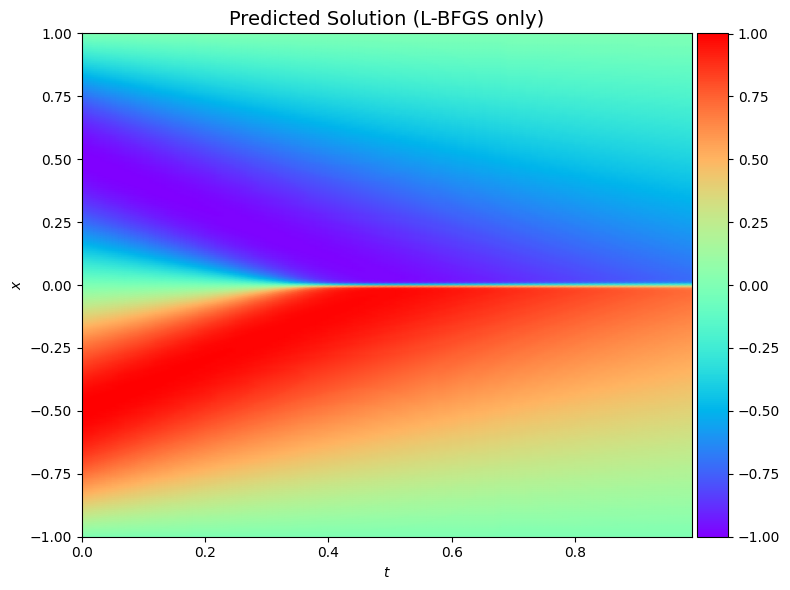

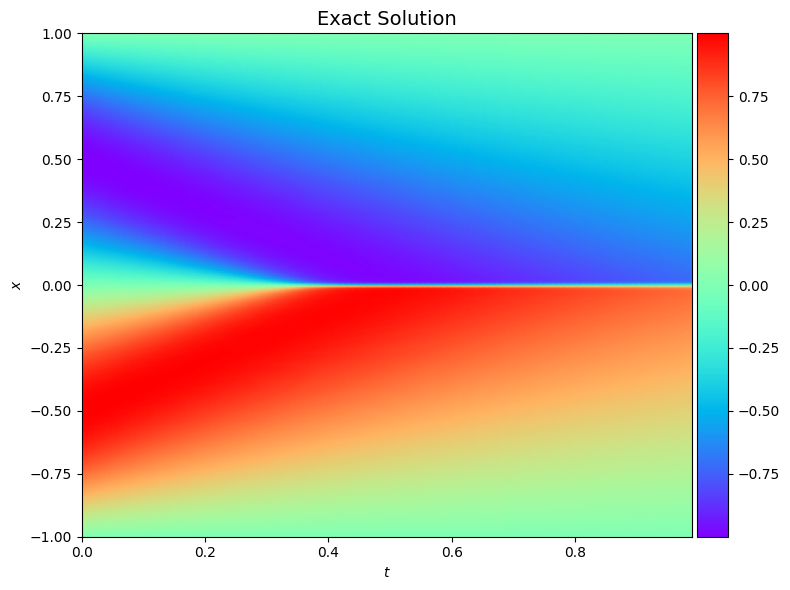

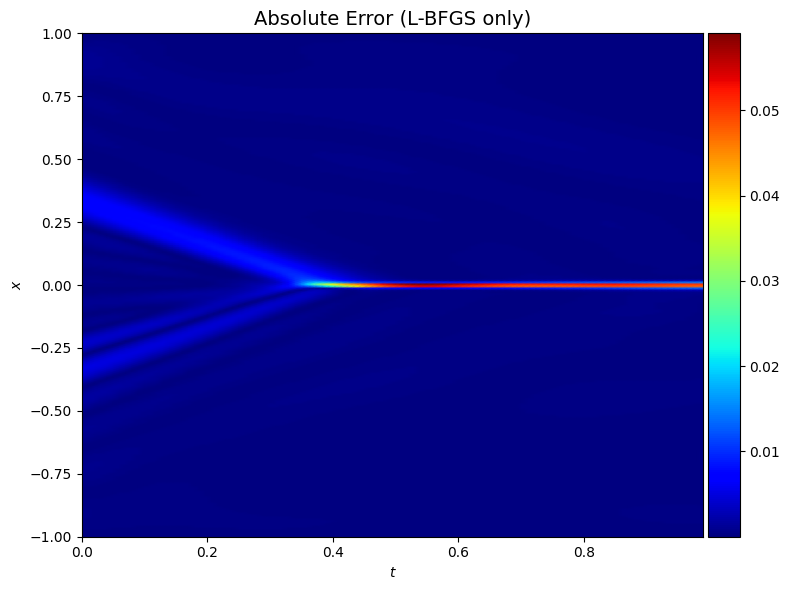

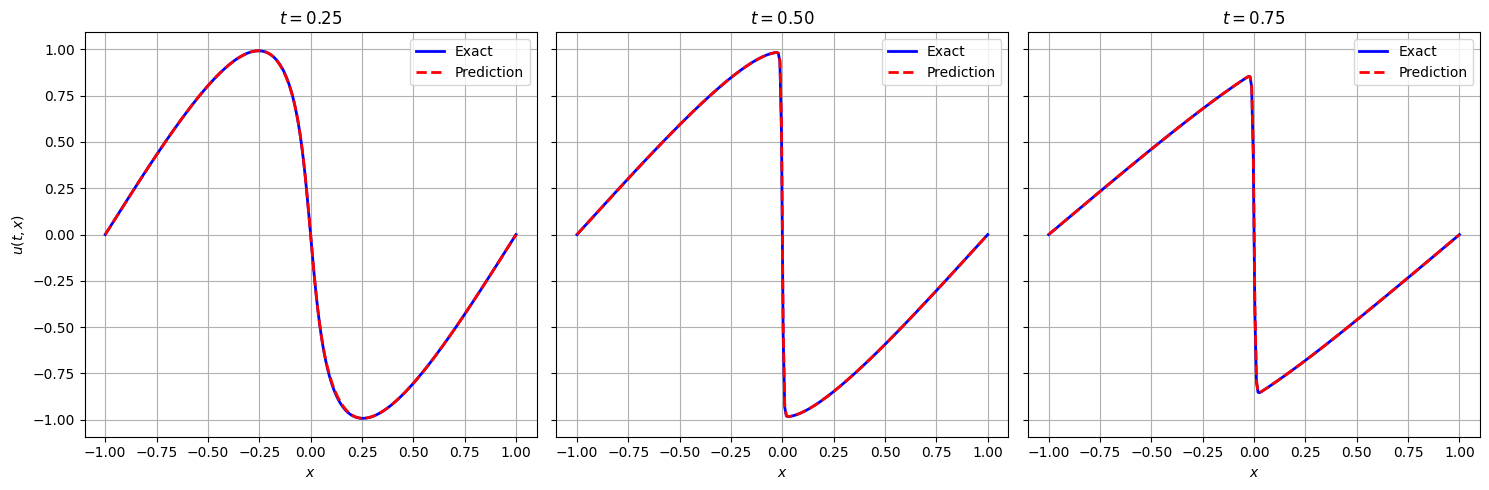

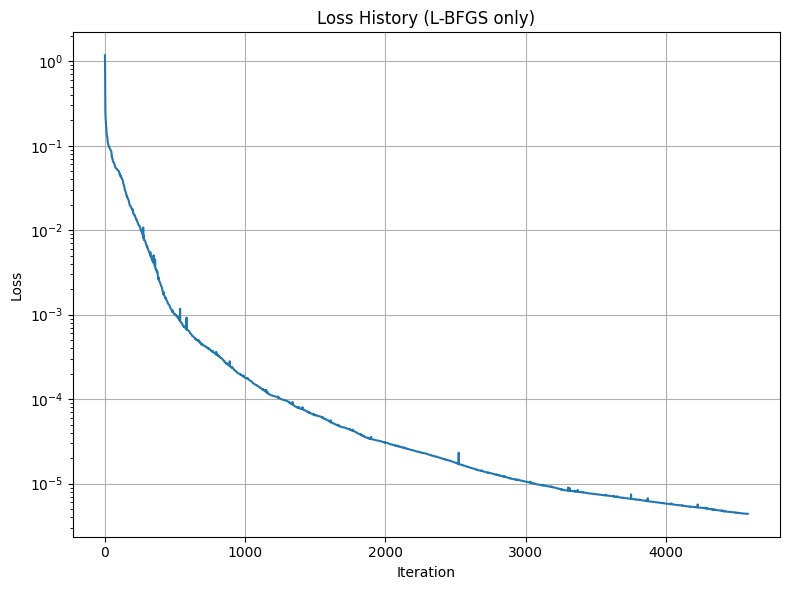

In [11]:
# Evaluate the model and plot the results.

# Set the model to evaluation mode
pinn_model_lbfgs.eval()

# Perform prediction on the entire domain
with torch.no_grad():
    u_pred_lbfgs = pinn_model_lbfgs(X_star_t)

# Calculate the relative L2 error to measure accuracy
error = relative_l2_error(u_pred_lbfgs, u_star_t)
print(f"Relative L2 Error (L-BFGS only): {error:.4e}")

# For plotting, we need to reshape the flat prediction vector back into a 2D grid
# We use griddata for interpolation to handle the unstructured query points
u_pred_grid_lbfgs = griddata(X_star, u_pred_lbfgs.cpu().numpy().flatten(), (X, T), method='cubic')

# --- Plotting ---

# Plot the predicted solution heatmap
plot_solution_heatmap(x, t, u_pred_grid_lbfgs, title="Predicted Solution (L-BFGS only)")

# Plot the exact solution for comparison
plot_solution_heatmap(x, t, Exact, title="Exact Solution")

# Plot the absolute error heatmap
plot_solution_heatmap(x, t, np.abs(Exact - u_pred_grid_lbfgs), title="Absolute Error (L-BFGS only)", cmap='jet')

# Plot snapshots at different times
plot_snapshots(x, t, Exact, u_pred_grid_lbfgs, snapshot_times=[0.25, 0.50, 0.75])

# Plot the loss history
plot_loss_history(loss_history_lbfgs, title="Loss History (L-BFGS only)")



## **7 Training - Improved Method (Adam + L-BFGS)**

Now, we train the same model architecture using our modern, two-phase approach. Adam will first find a good region in the loss landscape, and then L-BFGS will fine-tune the solution to a precise minimum.

In [13]:
# We use our hybrid trainer for better convergence.

# Re-initialize the model to start fresh for a fair comparison
pinn_model_hybrid = PhysicsInformedNN(layers, lb_t, ub_t).to(device)

# Define the loss function for this new model instance
def loss_fn_hybrid():
    # Data loss
    u_pred = pinn_model_hybrid(X_u_train_t)
    loss_data = torch.mean((u_train_t - u_pred)**2)
    
    # Physics loss
    u_phy = pinn_model_hybrid(X_f_train_t)
    
    # --- CORRECTED GRADIENT CALCULATION ---
    # Differentiate with respect to the input tensor X_f_train_t
    grads = torch.autograd.grad(u_phy, X_f_train_t, grad_outputs=torch.ones_like(u_phy), create_graph=True)[0]
    
    # Slice the gradients to get individual derivatives
    u_x = grads[:, 0:1]
    u_t = grads[:, 1:2]
    
    # Calculate the second derivative (u_xx)
    u_xx = torch.autograd.grad(u_x, X_f_train_t, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    # --- END OF CORRECTION ---
    
    residual = u_t + u_phy * u_x - nu * u_xx
    loss_pde = torch.mean(residual**2)
    
    return loss_data + loss_pde

# Setup optimizers for the hybrid training
optimizer_adam = torch.optim.Adam(pinn_model_hybrid.parameters(), lr=1e-3)
optimizer_lbfgs = torch.optim.LBFGS(
    pinn_model_hybrid.parameters(),
    max_iter=50000,
    max_eval=50000,
    history_size=50,
    tolerance_grad=1e-5,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe"
)

# Instantiate our custom trainer from src/training.py
import time
trainer = Trainer(pinn_model_hybrid, loss_fn_hybrid, optimizer_adam, optimizer_lbfgs)

# Train the model using the hybrid strategy
start_time = time.time()
trainer.train(adam_epochs=10000, lbfgs_epochs=1) # lbfgs_epochs > 0 triggers the L-BFGS phase
elapsed = time.time() - start_time
print(f"Hybrid Training time: {elapsed:.2f}s")


--- Starting Adam Optimization ---
Adam Epoch: 100/10000, Loss: 1.1937e-01, Time: 13.20s
Adam Epoch: 200/10000, Loss: 9.4206e-02, Time: 14.56s
Adam Epoch: 300/10000, Loss: 7.5499e-02, Time: 11.12s
Adam Epoch: 400/10000, Loss: 6.1986e-02, Time: 21.63s
Adam Epoch: 500/10000, Loss: 5.6916e-02, Time: 18.07s
Adam Epoch: 600/10000, Loss: 5.1945e-02, Time: 12.54s
Adam Epoch: 700/10000, Loss: 4.8386e-02, Time: 15.65s
Adam Epoch: 800/10000, Loss: 4.5263e-02, Time: 11.39s
Adam Epoch: 900/10000, Loss: 4.0992e-02, Time: 14.39s
Adam Epoch: 1000/10000, Loss: 3.3185e-02, Time: 11.65s
Adam Epoch: 1100/10000, Loss: 2.9636e-02, Time: 13.84s
Adam Epoch: 1200/10000, Loss: 2.5104e-02, Time: 15.07s
Adam Epoch: 1300/10000, Loss: 2.2170e-02, Time: 12.61s
Adam Epoch: 1400/10000, Loss: 1.9579e-02, Time: 13.99s
Adam Epoch: 1500/10000, Loss: 1.7826e-02, Time: 14.86s
Adam Epoch: 1600/10000, Loss: 1.6977e-02, Time: 12.18s
Adam Epoch: 1700/10000, Loss: 1.7675e-02, Time: 12.39s
Adam Epoch: 1800/10000, Loss: 1.3041e-0

## **8 Results and Visualization (Improved Method)**

Finally, we evaluate the hybrid-trained model and visualize its predictions to compare against the first run.

Relative L2 Error (Hybrid Method): 9.0110e-03


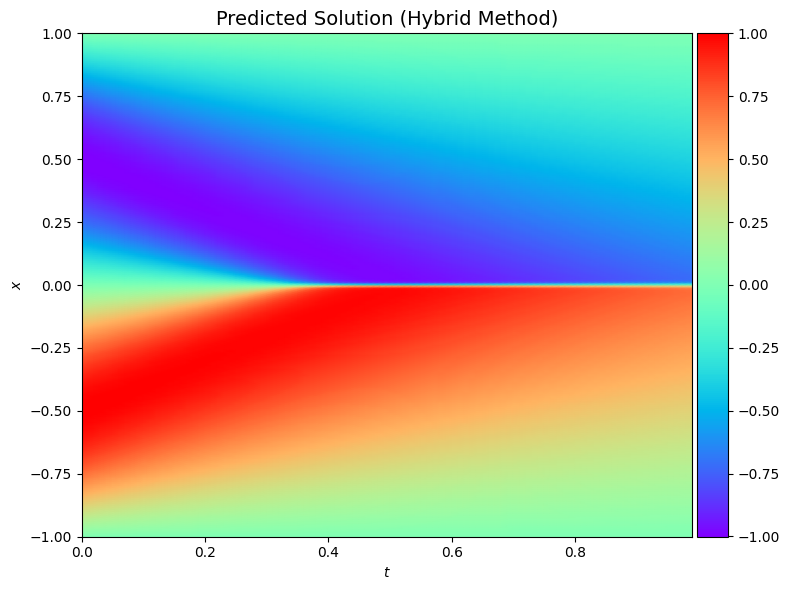

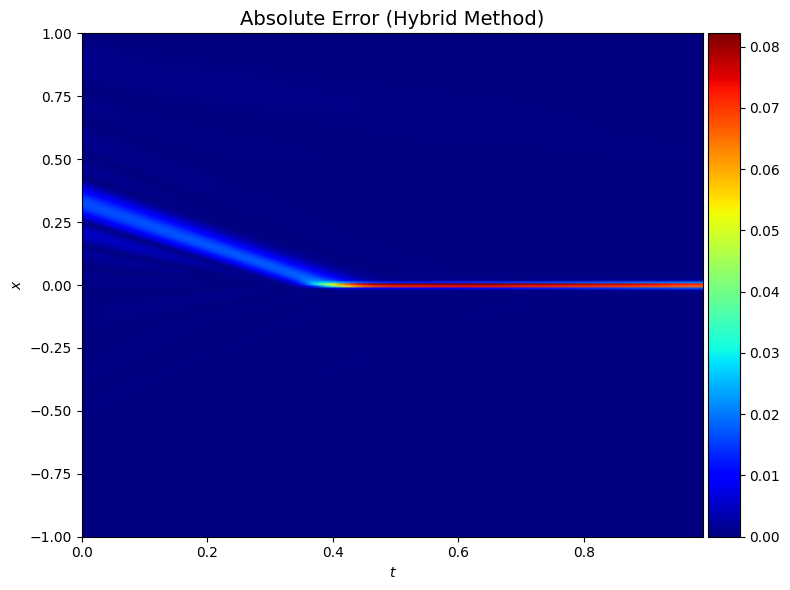

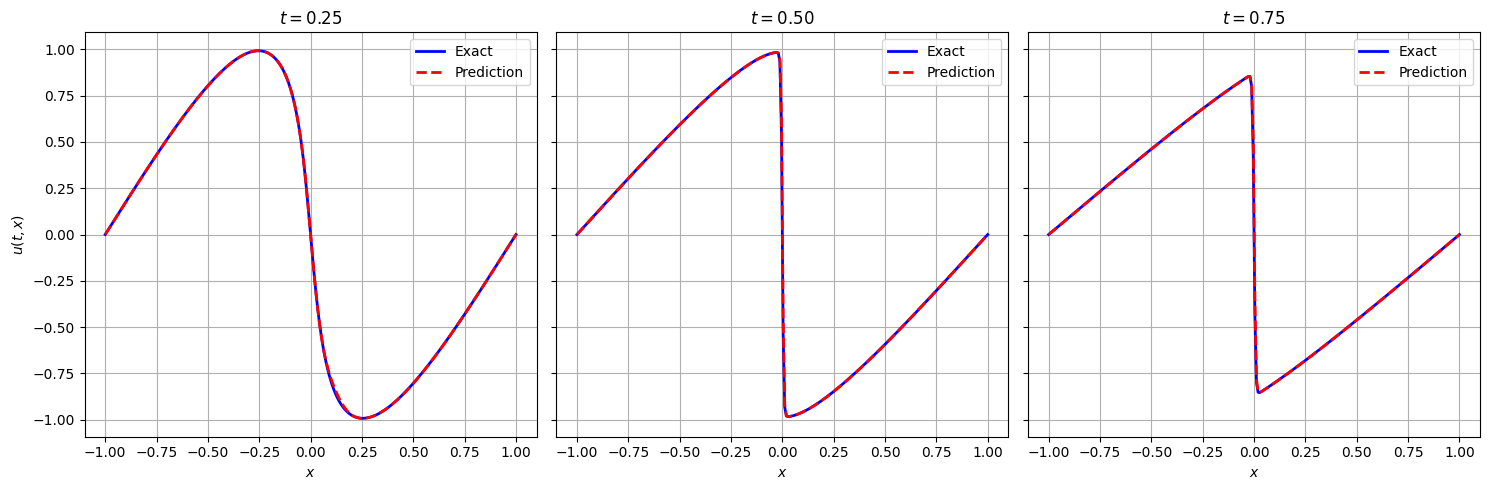

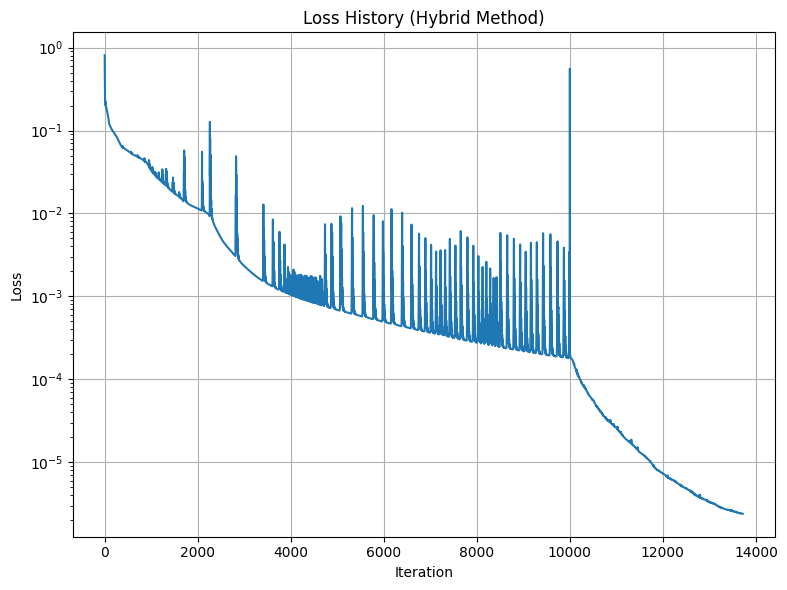

In [14]:
# Evaluate the hybrid-trained model and plot the results.

# Prediction
pinn_model_hybrid.eval()
with torch.no_grad():
    u_pred_hybrid = pinn_model_hybrid(X_star_t)

# Calculate L2 error
error_hybrid = relative_l2_error(u_pred_hybrid, u_star_t)
print(f"Relative L2 Error (Hybrid Method): {error_hybrid:.4e}")

# Reshape for plotting
u_pred_grid_hybrid = griddata(X_star, u_pred_hybrid.cpu().numpy().flatten(), (X, T), method='cubic')

# Plotting
plot_solution_heatmap(x, t, u_pred_grid_hybrid, title="Predicted Solution (Hybrid Method)")
plot_solution_heatmap(x, t, np.abs(Exact - u_pred_grid_hybrid), title="Absolute Error (Hybrid Method)", cmap='jet')
plot_snapshots(x, t, Exact, u_pred_grid_hybrid, snapshot_times=[0.25, 0.50, 0.75])
plot_loss_history(trainer.loss_history, title="Loss History (Hybrid Method)")



### **Cell 9: Conclusion and Comparison**

In this notebook, we aimed to solve the forward problem for the Burgers' equation and compare two optimization strategies. Let's analyze the final accuracy of the two methods based on our experimental results.

* **L-BFGS Only (Replication):** This method, replicating the original paper's approach, achieved a final relative L2 error of **`6.13e-3`**. While this is a reasonably accurate result, it did not reach the benchmark accuracy of `6.7e-4` reported by the original authors.

* **Adam + L-BFGS (Hybrid Method):** The hybrid strategy, intended to improve upon the first method, concluded with a final relative L2 error of **`9.01e-3`**. Unexpectedly, this was slightly less accurate than the L-BFGS-only approach in this specific run.

#### **Analysis of Training Instability**

Upon examining the training curve for the hybrid method, we can see a potential reason for its underperformance.



The loss history plot shows two distinct phases:
1.  **Adam Phase (Epochs 0-10,000):** The loss decreases steadily as Adam effectively navigates the broad loss landscape to find a promising region.
2.  **L-BFGS Phase (Epochs 10,000+):** When the optimizer switches to L-BFGS, there is an immediate, sharp drop in loss, which is expected. However, following this drop, the training is marked by several **sharp spikes where the loss temporarily increases.**

These spikes indicate a degree of **instability** during the fine-tuning phase. They suggest that the L-BFGS optimizer, in this high-dimensional loss landscape, may be overshooting the minimum at certain steps, causing it to "bounce around" rather than converging smoothly. This instability likely prevented the model from settling into the deeper, more accurate minimum that was targeted, ultimately leading to a higher final error.

While the hybrid optimization strategy is powerful in principle, this experiment highlights its sensitivity to the specific problem and hyperparameters. The oscillations suggest that further tuning (e.g., adjusting the L-BFGS learning rate or the point of transition from Adam) would be necessary to stabilize the training and outperform the simpler L-BFGS approach.

